In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer, WordNetLemmatizer

# Word2vec
import gensim

# SpaCy
from spacy.lang.en import English
import spacy

# Utility
import re
import numpy as np
import pandas as pd
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import pprint

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
TEXT_CLEANING_RE_NO_LINKS = "@\S+|https?:\S+|http?:\S"

In [ ]:
path = "/content/drive/MyDrive/Aml_Project/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
pd.set_option('display.max_colwidth',None)

In [ ]:
df1 = df[:100000]
df2 = df[-100000:]
frames = [df1, df2]
df = pd.concat(frames)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   ids     200000 non-null  int64 
 2   date    200000 non-null  object
 3   flag    200000 non-null  object
 4   user    200000 non-null  object
 5   text    200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


In [ ]:
df.groupby(['target']).count()

,ids,date,flag,user,text
target,,,,,
0,100000,100000,100000,100000,100000
4,100000,100000,100000,100000,100000


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
sentimentMap = {0: "NEGATIVE", 4: "POSITIVE"}

def decodeSentiment(label):
  return sentimentMap[int(label)]


In [ ]:
%%time
df.target = df.target.apply(lambda x: decodeSentiment(x))
display(df.head())

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


CPU times: user 104 ms, sys: 895 µs, total: 105 ms
Wall time: 116 ms


,ids,date,flag,user,text
target,,,,,
NEGATIVE,100000,100000,100000,100000,100000
POSITIVE,100000,100000,100000,100000,100000


Text(0.5, 1.0, 'Sentiment distribuition')

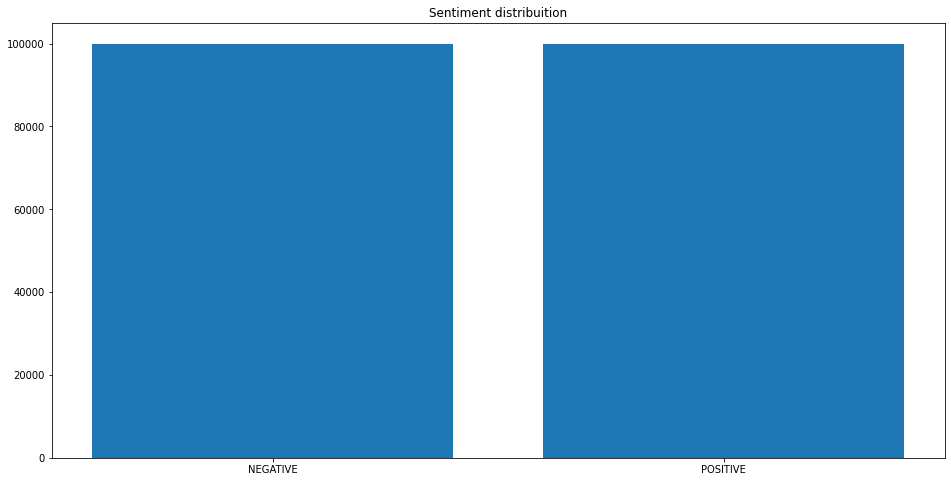

In [ ]:
display(df.groupby(['target']).count())

sentimentCount = Counter(df["target"])

plt.figure(figsize=(16,8))
plt.bar(sentimentCount.keys(), sentimentCount.values())
plt.title("Sentiment distribuition")

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [ ]:
def StemmingPreProcess(text, stem=True):
  # Remove link,user and special characters
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
      if token not in stop_words:
          if stem:
              tokens.append(stemmer.stem(token))
          else:
              tokens.append(token)
  return " ".join(tokens)

In [ ]:
def find_emo(text):
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
  return emoticons

In [ ]:
def removePunctuation(text):
  if type(text) == str:
    # text = re.sub('<[^>]*>', '', text)
    text = re.sub(TEXT_CLEANING_RE_NO_LINKS, '', text)
    text = re.sub('[\W]+', '', text.lower())
    return text

In [ ]:
rowCount=0

In [ ]:
# def LemmatizationPreProcess(text, nlp, tokenizer):
#   # spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
#   # spacy_stopwords is a hardcoded set

#   # for t in text:
#   #   tokens = tokenizer(str(t))
#   #   lemma_list = []
#   #   for token in tokens:
#   #     # if token.lemma_.lower() not in spacy_stopwords:
#   #     if not token.is_stop:
#   #       # lemma_list.append(token.lemma_)
#   #       token_preprocessed = removePunctuation(token.lemma_)
#   #       if token_preprocessed != '':
#   #         lemma_list.append(token_preprocessed)

#   # nlp = English()
#   # tokenizer = nlp.Defaults.create_tokenizer(nlp)

#   tokens = tokenizer(text)
#   # print(f"text: {str(text)}")
#   # tokens = tokenizer(str(text))
#   lemma_list = []
#   for token in tokens:
#     # if token.lemma_.lower() not in spacy_stopwords:
#     if not token.is_stop:
#       # lemma_list.append(token.lemma_)
#       token_preprocessed = removePunctuation(token.lemma_)
#       if token_preprocessed != '':
#         lemma_list.append(token_preprocessed)


#   # rowCount += 1
#   # print(f"rowCount: {rowCount}")
#   print(f"lemma list: {lemma_list}")
#   return " ".join(lemma_list)

In [ ]:
def LemmatizationPreProcess(text, nlp, tokenizer):
  # doc = nlp(text)
  # lemma_list = [str(tok.lemma_).lower() for tok in text
  #               if not tok.is_stop]

  lemma_list = []
  for tok in text:
    if not tok.is_stop:
      token_preprocessed = removePunctuation(str(tok.lemma_))
      if token_preprocessed != '':
        lemma_list.append(token_preprocessed)

  print(f"lemma list: {lemma_list}")
  # return lemma_list
  return " ".join(lemma_list)

In [ ]:
def preProcess(text, method, methodParam=True, nlp=None, tokenizer=None, rowCount=None):
  if method == "stem":
    return StemmingPreProcess(text, stem=methodParam)
  elif method == "lemma":
    # if rowCount is not None:
    #   rowCount += 1
    #   print(rowCount)

    preproc_pipe = []
    for doc in nlp.pipe(text, batch_size=1000):
        preproc_pipe.append(LemmatizationPreProcess(doc, nlp, tokenizer))
    return preproc_pipe

    # return LemmatizationPreProcess(text, nlp, tokenizer)

In [ ]:
# def preProcess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)

In [ ]:
%%time
dfNoStem = df.copy()
# display(dfNoStem.head())
dfNoStem.text = dfNoStem.text.apply(lambda x: preProcess(x, method="stem", methodParam=False))
# dfNoStem.text = dfNoStem.text.apply(lambda x: StemmingPreProcess(x, stem=False))
# dfNoStem.text = dfNoStem.text.apply(lambda x: preProcess(x, stem=False))
display(dfNoStem.head())

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


CPU times: user 7.46 s, sys: 27.2 ms, total: 7.49 s
Wall time: 7.52 s


In [ ]:
%%time
dfStem = df.copy()
dfStem.text = dfStem.text.apply(lambda x: preProcess(x, method="stem", methodParam=True))
display(dfStem.head())

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see


CPU times: user 31.1 s, sys: 55.7 ms, total: 31.2 s
Wall time: 31.2 s


In [ ]:
%%time
# rowCount=0
dfLemma = df.copy()

nlp = English()
# tokenizer = nlp.Defaults.create_tokenizer(nlp)

# dfLemma.text = dfLemma.text.apply(lambda x: preProcess(x, method="lemma", nlp, tokenizer))
# dfLemma.text = dfLemma.text.apply(lambda x: preProcess(x, method="lemma", nlp=nlp, tokenizer=tokenizer))

# lemma_text_series = pd.Series()
# for text in tokenizer.pipe(dfLemma.text):

# for text in dfLemma.text:
#   print(f"text: {text}")
#   print(type(text))
#   lemma_text_series.append(preProcess(text, method="lemma", nlp=nlp, tokenizer=tokenizer))
#   print(f"Len: {lemma_text_series.shape}")
# dfLemma["lemma_text"] = lemma_text_series

# dfLemma['lemma_text'] = preProcess(dfLemma['text'], method="lemma", nlp=nlp, tokenizer=tokenizer)
dfLemma['lemma_text'] = preProcess(dfLemma['text'], method="lemma", nlp=nlp)

display(dfLemma.head())

Streaming output truncated to the last 5000 lines.
lemma list: ['whinlatter', 'tonight', 'forests', 'amp', 'zipping']
lemma list: ['touch', 'pushing', 'updates', 'regularly']
lemma list: ['bariatric', 'fusion', 'taste', 'text', 'list', 'bc', 'way']
lemma list: ['thank']
lemma list: ['bb', 'tell']
lemma list: ['hey', 's', 'yeah', 'weekend', 'went', 'arse', 'lol', 'raining', 's', 'ya']
lemma list: ['erin', 'darling', 'found', 'twitter']
lemma list: ['chapter', 'lt3']
lemma list: ['not', 'great', '2', 'kno', 'god', '4', 'know', 'weapon', 'formed', 'shall', 'prosper']
lemma list: ['ant', 'learned', 'travel', 'twitter', 'posts']
lemma list: ['cheers', 'darl']
lemma list: ['thanks', 'chris', 'good', 'wagamama', 'takes', 'customer', 'service', 'satisfaction', 'seriously', 'nice']
lemma list: ['correct', 'comments']
lemma list: ['miss', 'amp', 'love']
lemma list: ['go', 'to', 'hectic', 'days', 'taking', 'today', 'chill', 'go', 'to', 'great']
lemma list: ['sure', 'probably', '12', 'step', 'grou

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad


CPU times: user 2min 32s, sys: 25.8 s, total: 2min 58s
Wall time: 2min 42s


In [ ]:
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
dfStem.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see


In [ ]:
dfLemma.head()

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad


In [ ]:
df = dfLemma.copy()
df["stem_text"] = dfStem["text"]
df.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad,behav mad see


In [ ]:
#df.to_csv("/content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/tweets_stem_lemma.csv")

In [ ]:
# df.to_excel("/content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/tweets_stem_lemma.xlsx")

In [ ]:
# df = dfStem.copy()

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 160000
TEST size: 40000


In [ ]:
df_train.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
89090,NEGATIVE,1755176981,Sun May 10 08:27:41 PDT 2009,NO_QUERY,theladyisugly,"Please, pray for my mom. She's not well, and it's almost entirely because of emotional stuff, like her family far away. Please #140Sunday",pray mom entirely emotional stuff like family far away 140sunday,pleas pray mom well almost entir emot stuff like famili far away pleas 140sunday
1584717,POSITIVE,2190596205,Tue Jun 16 03:10:55 PDT 2009,NO_QUERY,princezaleski,@cretakano now i'm here too sayang!,sayang,sayang
7865,NEGATIVE,1469978167,Tue Apr 07 07:59:19 PDT 2009,NO_QUERY,FROactiv,Seems like twitter is glitching again... Last two tweets have been stuck @ the top... *crawls back under social networking rock*,like twitter glitching tweets stuck crawls social networking rock,seem like twitter glitch last two tweet stuck top crawl back social network rock
1575384,POSITIVE,2189383528,Mon Jun 15 23:54:14 PDT 2009,NO_QUERY,JoannaGoff,@11points Funniest classified ads = sheer brilliance. Got promised laughs and so many life lessons as well.,funniest classified ads sheer brilliance got promised laughs life lessons,funniest classifi ad sheer brillianc got promis laugh mani life lesson well
1581254,POSITIVE,2190162984,Tue Jun 16 01:57:00 PDT 2009,NO_QUERY,tasjaa,@verresnoirs go ask your cell provider.. they should know what to do..,ask cell provider know,go ask cell provid know


In [ ]:
df_test.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
66092,NEGATIVE,1691334205,Sun May 03 17:37:47 PDT 2009,NO_QUERY,bbritton81,Ate a few kinda bad things this weekend and is now seriously regretting it,ate kinda bad things weekend seriously regretting,ate kinda bad thing weekend serious regret
1554161,POSITIVE,2184805884,Mon Jun 15 16:26:53 PDT 2009,NO_QUERY,VNessa22,wooow! and i thought I was late! Drake is JUST NOW a trending topic?! I've been listening to his mixtapes nonstop for quite some time now,wooow thought late drake trending topic listening mixtapes nonstop time,wooow thought late drake trend topic listen mixtap nonstop quit time
99339,NEGATIVE,1793588963,Thu May 14 03:16:10 PDT 2009,NO_QUERY,EmmaLeeInez,still storming..i dont wanna wait fot the bus in this emii(:,storming not wanna wait fot bus emii,still storm dont wanna wait fot bus emii
1563263,POSITIVE,2187021846,Mon Jun 15 19:40:32 PDT 2009,NO_QUERY,katiehillman,had a good day. Got to see my Jeanne',good day got jeanne,good day got see jeann
1562094,POSITIVE,2186743229,Mon Jun 15 19:16:23 PDT 2009,NO_QUERY,bailar_vivir,"@sroxy *snort* @ButchtasticKyle, normal? You've got to be KIDDING me.",snort normal got kidding,snort butchtastickyl normal got kid


In [ ]:
%%time
# documents = [_text.split() for _text in df_train.text] 
documents = [_text.split() for _text in df_train.stem_text] 

CPU times: user 465 ms, sys: 54.7 ms, total: 520 ms
Wall time: 532 ms


In [ ]:
documents[:3]

[['pleas',
  'pray',
  'mom',
  'well',
  'almost',
  'entir',
  'emot',
  'stuff',
  'like',
  'famili',
  'far',
  'away',
  'pleas',
  '140sunday'],
 ['sayang'],
 ['seem',
  'like',
  'twitter',
  'glitch',
  'last',
  'two',
  'tweet',
  'stuck',
  'top',
  'crawl',
  'back',
  'social',
  'network',
  'rock']]

In [ ]:
twtWordLst = [Counter(twt) for twt in documents]

In [ ]:
pprint.pprint(twtWordLst[:3])

[Counter({'pleas': 2,
          'pray': 1,
          'mom': 1,
          'well': 1,
          'almost': 1,
          'entir': 1,
          'emot': 1,
          'stuff': 1,
          'like': 1,
          'famili': 1,
          'far': 1,
          'away': 1,
          '140sunday': 1}),
 Counter({'sayang': 1}),
 Counter({'seem': 1,
          'like': 1,
          'twitter': 1,
          'glitch': 1,
          'last': 1,
          'two': 1,
          'tweet': 1,
          'stuck': 1,
          'top': 1,
          'crawl': 1,
          'back': 1,
          'social': 1,
          'network': 1,
          'rock': 1})]


In [ ]:
type(df.text)

pandas.core.series.Series

In [ ]:
textLst = df.text.to_list()

In [ ]:
len(textLst)

200000

In [ ]:
textLst[:2]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]

In [ ]:
countVector = CountVectorizer()

In [ ]:
# X=countVector.fit_transform(df.text.to_list())
X=countVector.fit_transform(df.stem_text.to_list())

In [ ]:
len(countVector.get_feature_names_out())

71800

In [ ]:
countVector.get_feature_names_out()[-50:]

array(['zuko', 'zula', 'zulu', 'zuma', 'zumba', 'zumez', 'zumo', 'zune',
       'zunit', 'zuowen', 'zuppalizzl', 'zur', 'zuraidah', 'zurairi',
       'zurich', 'zusammen', 'zut', 'zv', 'zveshi', 'zvezi', 'zvi',
       'zwame', 'zwart', 'zx', 'zydeco', 'zyder', 'zydrat', 'zyngapok',
       'zyrtec', 'zyrus', 'zz', 'zzi', 'zzs', 'zzz', 'zzzonk', 'zzzz',
       'zzzzs', 'zzzzz', 'zzzzzz', 'zzzzzzs', 'zzzzzzz', 'zzzzzzzz',
       'zzzzzzzzz', 'zzzzzzzzzz', 'zzzzzzzzzzz', 'zzzzzzzzzzzz',
       'zzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzs', 'zzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzz'], dtype=object)

In [ ]:
cvDict = countVector.vocabulary_

In [ ]:
len(cvDict)

71800

In [ ]:
type(cvDict)

dict

In [ ]:
i = 0
for k,v in cvDict.items():
  if i ==5:
    break
  i+=1
  print(k, v)



awww 6481
bummer 10941
shoulda 56157
got 26271
david 16745


In [ ]:
corpus = [
'This is the first document.',
'This document is the second document.',
'And this is the third one.',
'Is this the first document?',
]

vectorizer = CountVectorizer()
XY = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [ ]:
# vectorizer = CountVectorizer()
# XY = vectorizer.fit_transform(df.text.head().to_list())
# vectorizer.get_feature_names_out()[:10]

vectorizer = CountVectorizer()
XY = vectorizer.fit_transform(df.stem_text.head().to_list())
vectorizer.get_feature_names_out()[:10]

array(['50', 'also', 'awww', 'ball', 'behav', 'blah', 'bodi', 'bound',
       'bummer', 'carr'], dtype=object)

In [ ]:
# # Instantiate the CountVectorizer method
# count_vector = CountVectorizer()

# # Fit the training data and then return the matrix
# training_data = count_vector.fit_transform(df_train.text)

# # Transform testing data and return the matrix. 
# testing_data = count_vector.transform(df_test.text)

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(df_train.stem_text)

# Transform testing data and return the matrix. 
testing_data = count_vector.transform(df_test.stem_text)

In [ ]:
print (training_data.shape)

(160000, 62386)


In [ ]:
print (testing_data.shape)

(40000, 62386)


In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(training_data,df_train.target)

SVC(kernel='linear')

In [ ]:
#Make prediction on test dataset
predictions = clf.predict(testing_data)

In [ ]:
type(predictions)

numpy.ndarray

In [ ]:
predictions[:5]

array(['NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE'],
      dtype=object)

In [ ]:
df_test.target[:5]

66092      NEGATIVE
1554161    POSITIVE
99339      NEGATIVE
1563263    POSITIVE
1562094    POSITIVE
Name: target, dtype: object

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_test.target, predictions, pos_label="POSITIVE")))

Accuracy score: 0.760975
Precision score: 0.7511285859909713
Recall score: 0.7772754671488848
F1 score: 0.7639783751758868


In [ ]:
print(classification_report(df_test.target, predictions))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.74      0.76     20092
    POSITIVE       0.75      0.78      0.76     19908

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

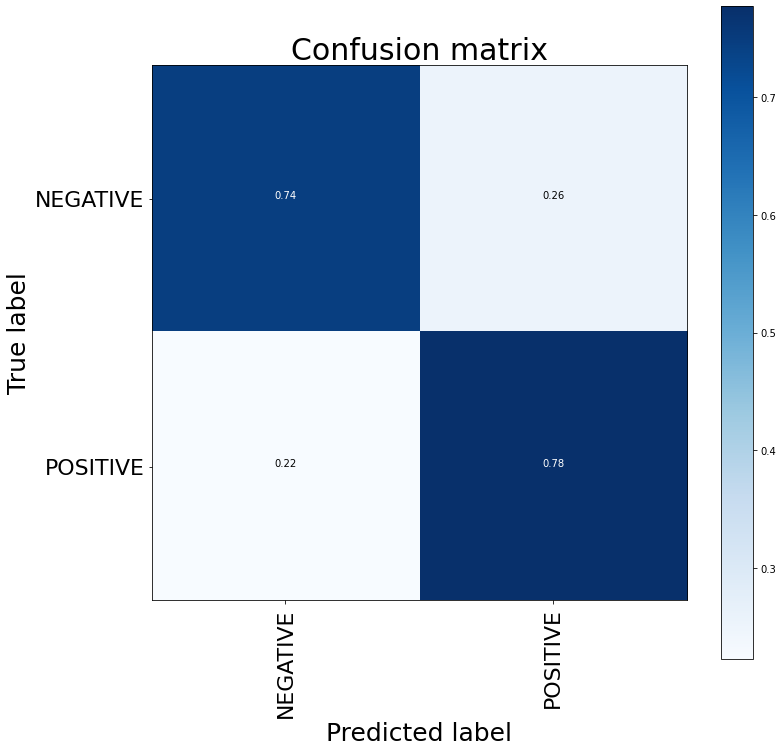

CPU times: user 485 ms, sys: 3.01 ms, total: 488 ms
Wall time: 488 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(df_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Now for Lemmatization Text

In [ ]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(df_train.lemma_text)

# Transform testing data and return the matrix. 
testing_data = count_vector.transform(df_test.lemma_text)

clf = svm.SVC(kernel='linear')
clf.fit(training_data,df_train.target)

#Make prediction on test dataset
predictions = clf.predict(testing_data)

print(type(predictions))

print(predictions[:5])

print(df_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_test.target, predictions))

<class 'numpy.ndarray'>
['NEGATIVE' 'POSITIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE']
66092      NEGATIVE
1554161    POSITIVE
99339      NEGATIVE
1563263    POSITIVE
1562094    POSITIVE
Name: target, dtype: object
Accuracy score: 0.75975
Precision score: 0.7484558965450685
Recall score: 0.7791340164757886
F1 score: 0.7634869068714315
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.74      0.76     20092
    POSITIVE       0.75      0.78      0.76     19908

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



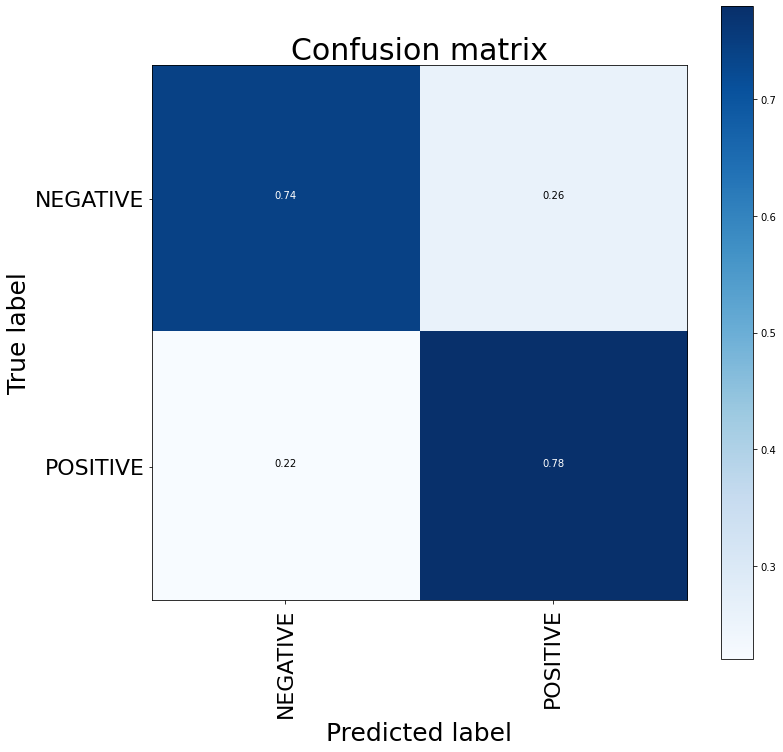

CPU times: user 510 ms, sys: 13 ms, total: 523 ms
Wall time: 520 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(df_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Sentiment_Analysis - Copy.ipynb"

[NbConvertApp] WARNING | pattern u'/content/drive/MyDrive/Sentiment_Analysis - Copy.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default base